## Volume Reversal Strategy.

First get the data to work on


In [56]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/AT2/Librerias'
#%ls
!pip install import_ipynb
import import_ipynb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import yahoo_reader as yr 

mydata = yr.odata('ZM', datetime(2019, 4, 1),datetime(2020, 4, 1))
display(mydata.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AT2/Librerias


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-04-18,66.000000,60.320999,65.000000,62.000000,25764700,62.000000
2019-04-22,68.900002,59.939999,61.000000,65.699997,9949700,65.699997
2019-04-23,74.168999,65.550003,66.870003,69.000000,6786500,69.000000
2019-04-24,71.500000,63.160000,71.400002,63.200001,4973500,63.200001
2019-04-25,66.849998,62.599998,64.739998,65.000000,3863300,65.000000


*    To identify significant price movements accompanied with a decrease in trading volume. 
*    Enter a position when the following are fulfilled: 
    1.   $5-$day absolute price change $> \ 100-$day standard deviation 
    2.   $5-$day average volume < $75\%$  of $10$ to$5-$day average volume.   
    3.   Long if the $5-$day price change is negative, otherwise enter short.

Therefore we must create:
1.   $5$ days average price change (shifted one day) since the strategy works with previous days info.
2.   $100-$dy std.
3.   $5-$day avg vol.
4.   $5$ to $10$-days avg vol.

In [57]:
## Price change for five days
mydata['pchg'] = mydata['Close'].shift(1)-mydata['Close'].shift(6)

## Standard deviation for 100-day price change
mydata['std_100day'] = mydata['pchg'].rolling(window=100).std()

## Average volume traded
mydata['5d_avg_vol'] = mydata['Volume'].shift(1).rolling(window=5).mean()

## Average volume traded between last 5 to 10 days
mydata['past 5d_avg_vol'] = mydata['5d_avg_vol'].shift(5)

display(mydata.tail())

,High,Low,Open,Close,Volume,Adj Close,pchg,std_100day,5d_avg_vol,past 5d_avg_vol
Date,,,,,,,,,,
2020-03-26,146.649994,138.199997,140.509995,141.149994,9252700,141.149994,19.400002,8.498173,18989360.0,14171580.0
2020-03-27,154.970001,145.600006,145.699997,151.699997,13271900,151.699997,17.379997,8.608002,17590220.0,15001680.0
2020-03-30,161.690002,147.199997,160.759995,150.880005,15762200,150.880005,21.149994,8.777782,17470080.0,15929500.0
2020-03-31,149.789993,143.356995,147.020004,146.119995,10023700,146.119995,-8.679993,8.866528,15086220.0,18023660.0
2020-04-01,144.600006,135.179993,144.500000,137.000000,11453300,137.000000,10.940002,8.892693,12610700.0,18759620.0


Create the Long and short sigmanls

In [0]:
## Signal column
mydata['signal'] = 0

## Buy Signal 
mydata.loc[((mydata['pchg'].abs() > mydata['std_100day']) & (mydata['5d_avg_vol'] < mydata['past 5d_avg_vol']) & (mydata['pchg'] < 0)), 'signal'] = 1

##Sell signal
mydata.loc[((mydata['pchg'].abs() > mydata['std_100day']) & (mydata['5d_avg_vol'] < mydata['past 5d_avg_vol']) & (mydata['pchg'] > 0)), 'signal'] = -1

In [59]:
display(mydata.tail(25))

,High,Low,Open,Close,Volume,Adj Close,pchg,std_100day,5d_avg_vol,past 5d_avg_vol,signal
Date,,,,,,,,,,,
2020-02-27,118.000000,107.599998,109.430000,113.550003,13511800,113.550003,2.949997,5.665873,9855720.0,4154900.0,0
2020-02-28,121.930000,97.370003,121.070000,105.000000,21711000,105.000000,8.260002,5.689153,10299440.0,6079320.0,0
2020-03-02,114.500000,102.500000,109.349998,113.110001,10157400,113.110001,3.239998,5.690597,13537800.0,6501880.0,0
2020-03-03,119.199997,112.110001,114.550003,117.470001,11033700,117.470001,8.099998,5.727142,13134720.0,8477440.0,0
2020-03-04,119.970001,113.110001,118.510002,116.800003,12102600,116.800003,10.389999,5.779519,12656280.0,10040980.0,0
2020-03-05,129.830002,110.000000,110.250000,125.000000,28149400,125.000000,9.920006,5.829419,13703300.0,9855720.0,0
2020-03-06,122.000000,107.000000,119.650002,114.320000,22975700,114.320000,11.449997,5.854423,16630820.0,10299440.0,0
2020-03-09,116.500000,100.879997,105.000000,113.750000,14571300,113.750000,9.320000,5.852759,16883760.0,13537800.0,0
2020-03-10,113.800003,105.000000,113.800003,108.489998,10244000,108.489998,0.639999,5.793305,17766540.0,13134720.0,0


*    Exit the position when one of the following is fulfilled: 
   1.    Be in position for five days 
   2.    If a counter signal is generated.

In [60]:
## C_signals and Exit signal. c_signal is continuous signal, counts the number of days. exit is the exit criterion
mydata['c_signal'] = 0
mydata['exit'] = 0


## Entry and Exit signal
for i in range(len(mydata)):
#First, we check if a new signal is generated, if it is then we will assign the c_signal column equal to the new signal, and then we update the exit criterion according to the signal generated. In this case, we will check if the signal is 1 if it is so, then we will mark the exit count as 1 otherwise, we will mark it as -1.
    if (mydata.iloc[i]['signal'] != 0) & (mydata.iloc[i]['signal'] != mydata.iloc[i - 1]['c_signal']):
        mydata.iloc[i, mydata.columns.get_loc('c_signal')] = mydata.iloc[i, mydata.columns.get_loc('signal')]
        if mydata['signal'][i] == 1:
            mydata.iloc[i, mydata.columns.get_loc('exit')] = 1
        else:
            mydata.iloc[i, mydata.columns.get_loc('exit')] = -1
#Second, we check if the entry signal is same as the existing position. If it is so, then we will update the exit criterion depending on the position. For example, if you are already long then your c_signal would be 1, hence it will be incremented by 1. If you are short then your c_signal is -1 and your exit will be reduced by 1.
    if (mydata['signal'][i] != 0) & (mydata['signal'][i] == mydata['c_signal'][i - 1]):
        mydata.iloc[i, mydata.columns.get_loc('c_signal')] = mydata['c_signal'][i - 1]
        if mydata['c_signal'][i - 1] == 1:
            mydata.iloc[i, mydata.columns.get_loc('exit')] = int(mydata['exit'][i - 1]) + 1
        else:
            mydata.iloc[i, mydata.columns.get_loc('exit')] = int(mydata['exit'][i - 1]) - 1
#After this, we will update the exit criterion for an already existing long trade. We check if the exit value of the c_signal is less 5 days old, if this is the case then we verify if the continuing signal is same as the previous days then we increment the exit by 1.
    if (mydata['signal'][i] == 0) & (mydata['exit'][i - 1] < 5) & (mydata['exit'][i - 1] > 0):
        mydata.iloc[i, mydata.columns.get_loc('c_signal')] = mydata['c_signal'][i - 1]
        mydata.iloc[i, mydata.columns.get_loc('exit')] = int(mydata['exit'][i - 1]) + 1
#Just as in the above step, we will update the exit criterion for an already existing short trade.
    if (mydata['signal'][i] == 0) & (mydata['exit'][i - 1] > -5) & (mydata['exit'][i - 1] < 0):
        mydata.iloc[i, mydata.columns.get_loc('c_signal')] = mydata['c_signal'][i - 1]
        mydata.iloc[i, mydata.columns.get_loc('exit')] = int(mydata['exit'][i - 1]) - 1
# update the exit criterion to 0 on the fifth day after entering the trade. This is one of the conditions of the strategy and accordingly we will close all positions on their 5th day.
    if (mydata['signal'][i] == 0) & ((mydata['exit'][i - 1] == 5) | (mydata['exit'][i - 1] == -5)):
        mydata.iloc[i, mydata.columns.get_loc('c_signal')] = 0
        mydata.iloc[i, mydata.columns.get_loc('exit')] = 0

display(mydata.tail(25))

,High,Low,Open,Close,Volume,Adj Close,pchg,std_100day,5d_avg_vol,past 5d_avg_vol,signal,c_signal,exit
Date,,,,,,,,,,,,,
2020-02-27,118.000000,107.599998,109.430000,113.550003,13511800,113.550003,2.949997,5.665873,9855720.0,4154900.0,0,0,0
2020-02-28,121.930000,97.370003,121.070000,105.000000,21711000,105.000000,8.260002,5.689153,10299440.0,6079320.0,0,0,0
2020-03-02,114.500000,102.500000,109.349998,113.110001,10157400,113.110001,3.239998,5.690597,13537800.0,6501880.0,0,0,0
2020-03-03,119.199997,112.110001,114.550003,117.470001,11033700,117.470001,8.099998,5.727142,13134720.0,8477440.0,0,0,0
2020-03-04,119.970001,113.110001,118.510002,116.800003,12102600,116.800003,10.389999,5.779519,12656280.0,10040980.0,0,0,0
2020-03-05,129.830002,110.000000,110.250000,125.000000,28149400,125.000000,9.920006,5.829419,13703300.0,9855720.0,0,0,0
2020-03-06,122.000000,107.000000,119.650002,114.320000,22975700,114.320000,11.449997,5.854423,16630820.0,10299440.0,0,0,0
2020-03-09,116.500000,100.879997,105.000000,113.750000,14571300,113.750000,9.320000,5.852759,16883760.0,13537800.0,0,0,0
2020-03-10,113.800003,105.000000,113.800003,108.489998,10244000,108.489998,0.639999,5.793305,17766540.0,13134720.0,0,0,0


Finally, backtest to check the results

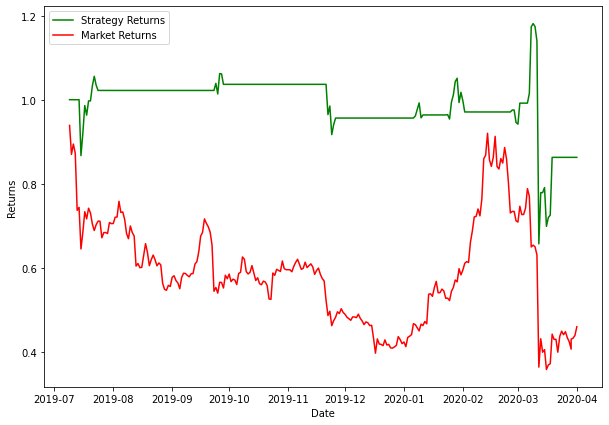

Sharpe =  0.9089380139625604


In [0]:
## Market returns
rets = mydata['Close'].pct_change()

## Strategy returns
str_ret = rets*mydata['c_signal']

## Cumulative Returns
mydata['cu_str_return'] = 0
mydata['cu_mar_return'] = 0
mydata.iloc[100:,mydata.columns.get_loc('cu_str_return')]= (str_ret[100:]+1).cumprod()
mydata.iloc[100:,mydata.columns.get_loc('cu_mar_return')]= (rets[100:]+1).cumprod()

## Plot the returns 
plt.figure(figsize=(10, 7))
plt.plot(mydata['cu_str_return'][100:], color='g', label='Strategy Returns')
plt.plot(mydata['cu_mar_return'][100:], color='r', label='Market Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

## Sharpe Ratio
print('Sharpe = ',(mydata['cu_str_return'].iloc[-1]-mydata['cu_mar_return'].iloc[-1])/mydata['cu_str_return'].std())